# Fx-LMS Algorithm Implementation for ANC Headset

## Overview
The Active Noise Cancellation (ANC) headset suppresses road traffic noise (100 Hz–1 kHz) while preserving speech, targeting 20 dB attenuation within 300 ms and <2% speech distortion. The **Filtered-x Least Mean Squares (Fx-LMS)** algorithm adaptively generates anti-noise to cancel noise at the ear-mic. This section describes the Fx-LMS implementation with a variable step-size based on normalized misalignment, the roles of the primary path ($P(z)$) and secondary path ($S(z)$), and the block diagram of the system model. The implementation is optimized for the ARM-A55 processor’s constraints (200 MHz MIPS, 128 kB RAM).

## System Model
The block diagram below illustrates the ANC system:
- **Primary Path $P(z)$**: A 10-tap FIR filter modeling the acoustic path from external noise $n(k)$ and speech $s(k)$ to the ear-mic, producing the desired signal:
  $$ d(k) = P(z) * (n(k) + s(k)) $$
- **Secondary Path $S(z)$**: A 5-tap FIR filter modeling the path from the loudspeaker (anti-noise $y(k)$) to the ear-mic, affecting the error:
  $$ e(k) = d(k) - S(z) * y(k) $$
- **Reference Signal $x(k)$**: Noise from the reference mic, assumed equal to $n(k)$.
- **DSP**: Generates $y(k) = w(k)^T x(k)$ using a 64-tap adaptive filter $W(z)$.
- **Goal**: Adjust $w(k)$ so $S(z) * y(k) \approx P(z) * n(k)$, making $e(k) \approx s(k)$.

## Fx-LMS Algorithm
The Fx-LMS algorithm updates the filter coefficients:
$$ w(k+1) = w(k) + \mu(k) \cdot e(k) \cdot x_f(k) $$
- $x_f(k) = S(z) * x(k)$: Filtered reference signal.
- $\mu(k)$: Variable step-size based on normalized misalignment:
  $$ \mu(k) = \frac{\mu_{\text{max}}}{\sigma_x^2 + \epsilon} $$
  where $\sigma_x^2(k) = \alpha \cdot \sigma_x^2(k-1) + (1-\alpha) \cdot x_f(k)^2$, $\alpha = 0.99$, and $\epsilon = 10^{-6}$.
- This ensures stable convergence within 300 ms for road noise (e.g., CHiME-4 dataset).

## Implementation Notes
The Python code below:
- Generates a block diagram using Matplotlib, showing signal flow ($n(t)$, $s(t)$ → $P(z)$ → $d(t)$ → $e(t)$, $x(t)$ → DSP → $y(t)$ → $S(z)$ → $e(t)$).
- Implements Fx-LMS with a 10-tap $P(z)$, 5-tap $S(z)$, and 64-tap $W(z)$.
- Uses simulated noise (100 Hz–1 kHz) and speech (500 Hz tone), with placeholders for CHiME-4 data.
- Plots clean speech, noise at ear, noisy signal, error, anti-noise, enhanced signal, and frequency-domain attenuation to verify 20 dB reduction in 100–1000 Hz.


# Code

In [24]:
!pip3 install librosa matplotlib scipy numpy Graphviz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


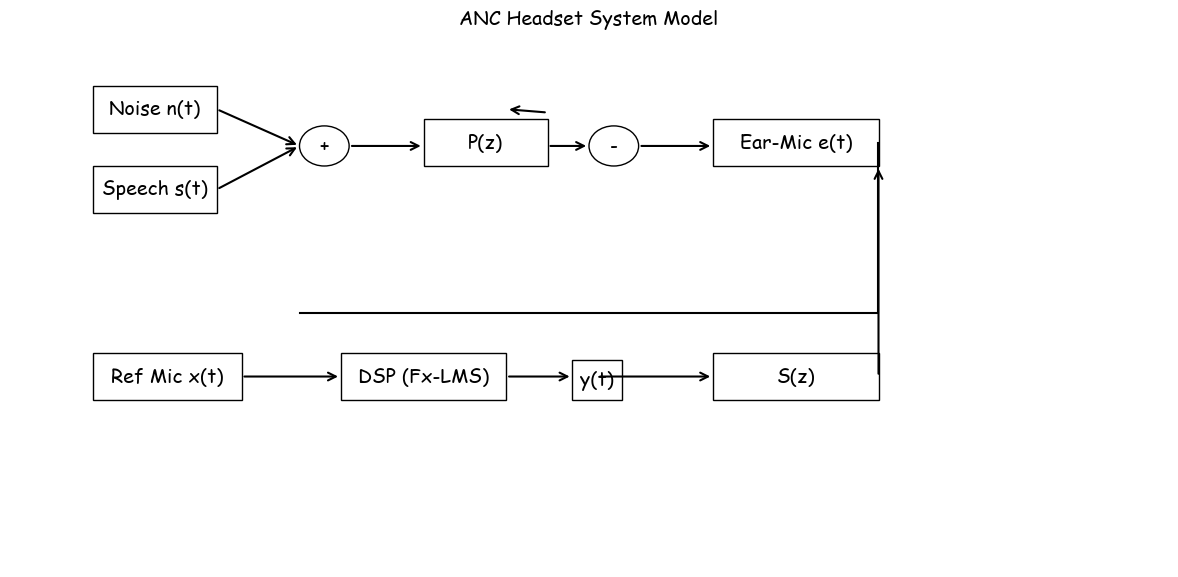

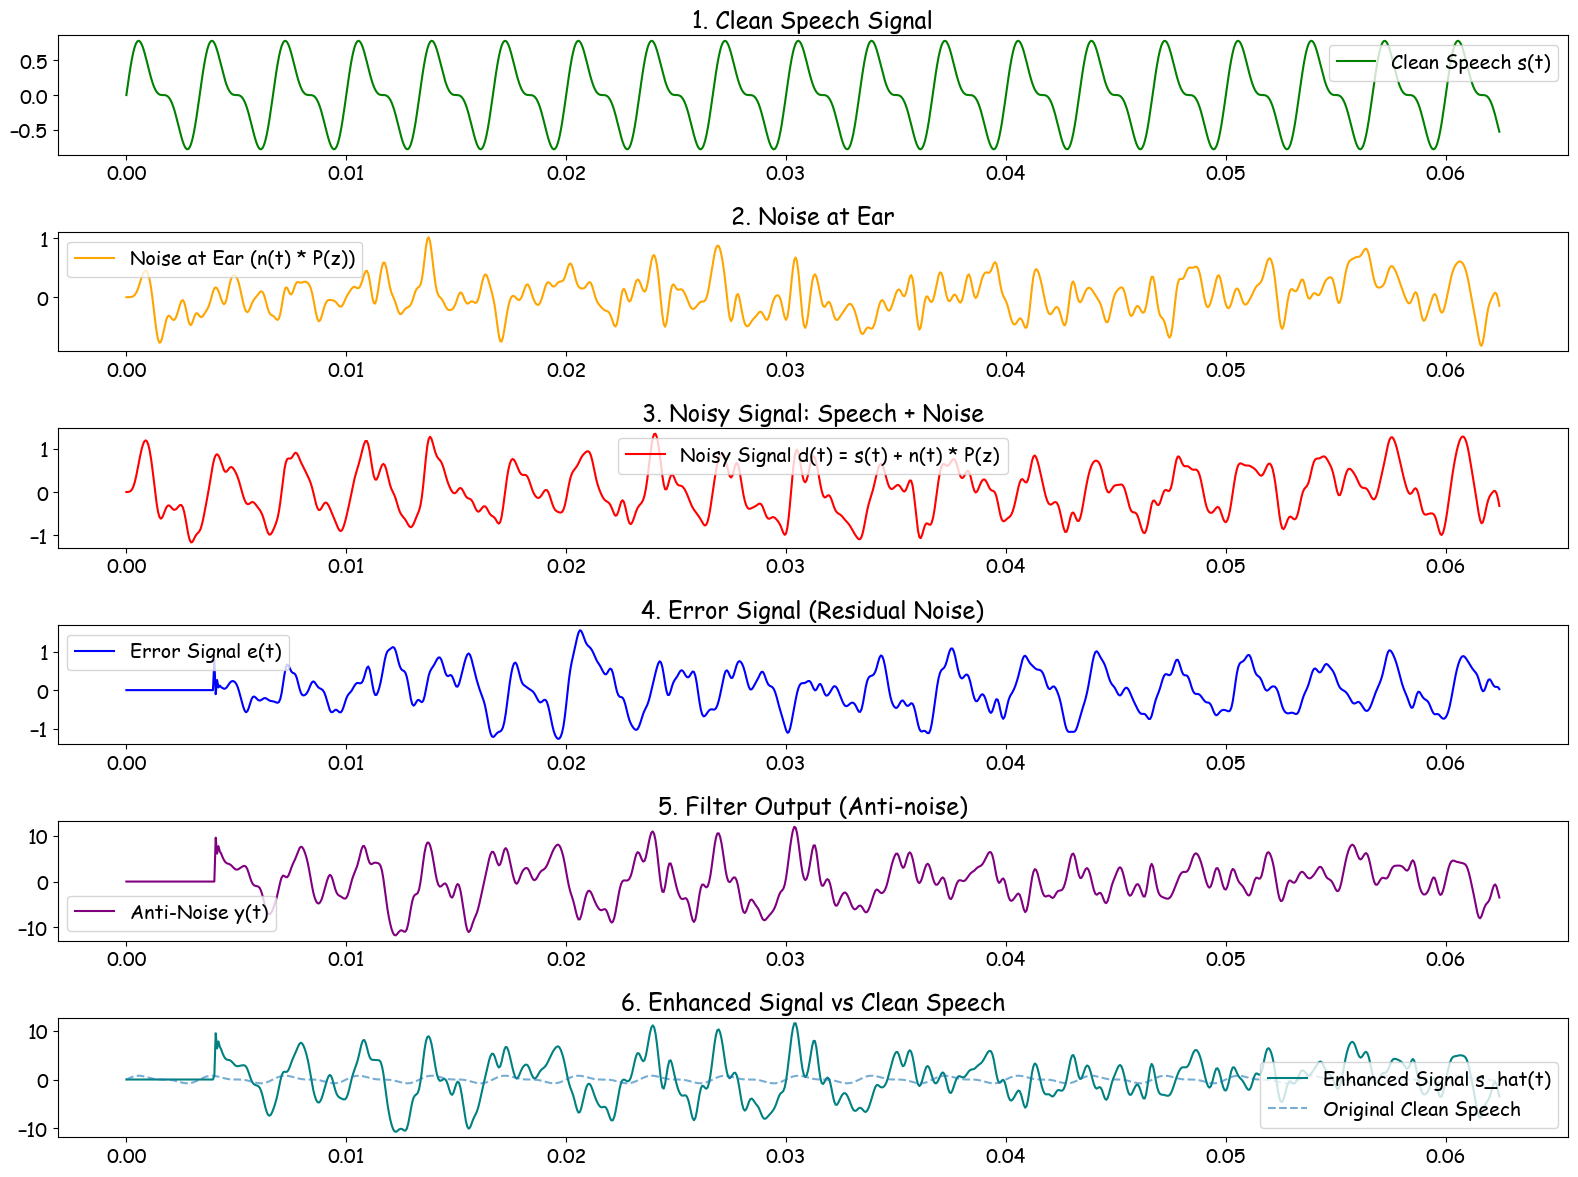

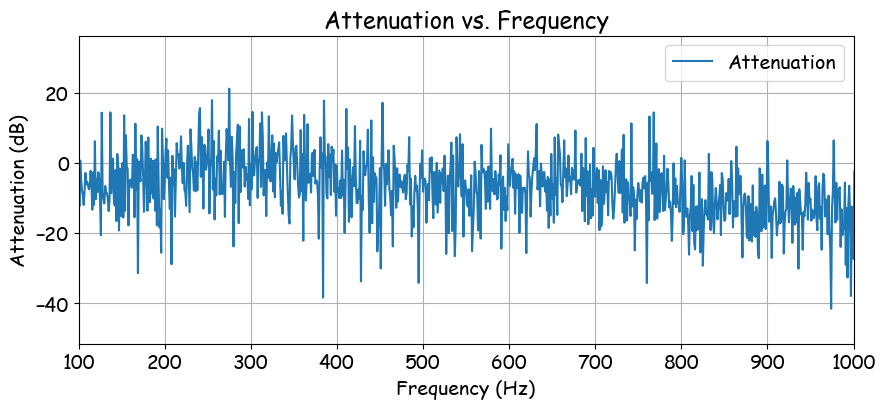

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.signal import firwin, lfilter
import librosa


# === Block Diagram ===
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)
ax.axis('off')

# Define blocks (x, y, width, height, label)
blocks = [
    (1, 6.5, 1.5, 0.7, 'Noise n(t)'),
    (1, 5.3, 1.5, 0.7, 'Speech s(t)'),
    (3.5, 6.0, 0.6, 0.6, '+'),
    (5, 6.0, 1.5, 0.7, 'P(z)'),
    (7, 6.0, 0.6, 0.6, '-'),
    (8.5, 6.0, 2, 0.7, 'Ear-Mic e(t)'),
    (1, 2.5, 1.8, 0.7, 'Ref Mic x(t)'),
    (4, 2.5, 2, 0.7, 'DSP (Fx-LMS)'),
    (6.8, 2.5, 0.6, 0.6, 'y(t)'),
    (8.5, 2.5, 2, 0.7, 'S(z)')
]

# Draw blocks
for x, y, w, h, label in blocks:
    if label in ['+', '-']:
        ax.add_patch(patches.Circle((x + w / 2, y + h / 2), h / 2, fill=False))
    else:
        ax.add_patch(patches.Rectangle((x, y), w, h, fill=False))
    ax.text(x + w / 2, y + h / 2, label, ha='center', va='center')

# Draw arrows
def draw_arrow(x1, y1, x2, y2):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=1.5))

draw_arrow(2.5, 6.85, 3.5, 6.3)       # Noise → +
draw_arrow(2.5, 5.65, 3.5, 6.3)       # Speech → +
draw_arrow(4.1, 6.3, 5, 6.3)          # + → P(z)
draw_arrow(6.5, 6.3, 7, 6.3)          # P(z) → -
draw_arrow(7.6, 6.3, 8.5, 6.3)        # - → Ear-Mic
draw_arrow(2.8, 2.85, 4, 2.85)        # Ref Mic → DSP
draw_arrow(6, 2.85, 6.8, 2.85)       # DSP → y(t)
draw_arrow(7.1, 2.85, 8.5, 2.85)     # y(t) → S(z)
draw_arrow(10.5, 2.85, 10.5, 6.0)    # S(z) → -
ax.plot([10.5, 10.5, 3.5], [6.35, 3.8, 3.8], 'k-')  # Feedback path
draw_arrow(3.5, 3.8, 4, 2.85)        # Feedback → DSP

plt.title('ANC Headset System Model', fontsize=14)
plt.tight_layout()
plt.savefig('anc_headset_model.png', dpi=300)
plt.show()

# === Fx-LMS Implementation ===
# Parameters
fs = 16000  # Sampling rate
N = 64      # Filter length
mu_max = 0.01  # Max step-size
epsilon = 1e-6  # Avoid division by zero
alpha = 0.99   # Smoothing factor
T = 1.0        # Duration (seconds)
t = np.arange(0, T, 1/fs)

# Signals (simulated, replaced the CHiME-4 dataset with simulated ones due to CHiME-4 being paid)
np.random.seed(42)
n_t = lfilter(firwin(11, 1000/(fs/2)), 1, np.random.randn(len(t)))  # Noise
s_t = 0.6 * np.sin(2 * np.pi * 300 * t) + 0.3 * np.sin(2 * np.pi * 600 * t)  # Speech
x_t = n_t  # Reference mic

# # Load CHiME-4 (if available)
# try:
#     x_t, sr = librosa.load('chime4_road_noise.wav', sr=fs)
#     s_t, sr = librosa.load('speech.wav', sr=fs)
#     if sr != fs:
#         raise ValueError("Sample rate mismatch")
#     x_t = x_t[:int(T * fs)]  # Truncate to T seconds
#     s_t = s_t[:int(T * fs)]
# except FileNotFoundError:
#     print("CHiME-4 files not found, using simulated signals")

# Primary and secondary paths
P = firwin(11, 1000/(fs/2))  # 10-tap primary path
S = np.array([0.1, 0.5, 0.8, 0.5, 0.1])  # 5-tap secondary path
d_t = lfilter(P, 1, n_t + s_t)  # Desired signal
x_f = lfilter(S, 1, x_t)  # Filtered reference

# Fx-LMS
w = np.zeros(N)
e_t = np.zeros(len(t))
y_t = np.zeros(len(t))
s_hat = np.zeros(len(t))
sigma_x = 0.01  # Initial power estimate
for n in range(N, len(t)):
    x_vec = x_t[n:n-N:-1]  # Input vector
    y_t[n] = w @ x_vec  # Anti-noise
    y_s = lfilter(S, 1, [y_t[n]])[0]  # S(z) * y(t)
    e_t[n] = d_t[n] - y_s  # Error
    s_hat[n] = e_t[n] + y_t[n]  # Enhanced signal
    sigma_x = alpha * sigma_x + (1 - alpha) * x_f[n]**2  # Update power
    mu = mu_max / (sigma_x + epsilon)  # Variable step-size
    w += mu * e_t[n] * x_f[n:n-N:-1]  # Update weights

# === Plots ===
plt.figure(figsize=(16, 12))

plt.subplot(6, 1, 1)
plt.plot(t[:1000], s_t[:1000], label="Clean Speech s(t)", color='green')
plt.title("1. Clean Speech Signal")
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(t[:1000], lfilter(P, 1, n_t)[:1000], label="Noise at Ear (n(t) * P(z))", color='orange')
plt.title("2. Noise at Ear")
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(t[:1000], d_t[:1000], label="Noisy Signal d(t) = s(t) + n(t) * P(z)", color='red')
plt.title("3. Noisy Signal: Speech + Noise")
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(t[:1000], e_t[:1000], label="Error Signal e(t)", color='blue')
plt.title("4. Error Signal (Residual Noise)")
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(t[:1000], y_t[:1000], label="Anti-Noise y(t)", color='purple')
plt.title("5. Filter Output (Anti-noise)")
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(t[:1000], s_hat[:1000], label="Enhanced Signal s_hat(t)", color='teal')
plt.plot(t[:1000], s_t[:1000], '--', label="Original Clean Speech", alpha=0.6)
plt.title("6. Enhanced Signal vs Clean Speech")
plt.legend()

plt.tight_layout()
plt.savefig('fxlms_results.png', dpi=300)
plt.show()

# Frequency-domain attenuation
plt.figure(figsize=(10, 4))
freq = np.fft.fftfreq(len(t), 1/fs)[:len(t)//2]
D_f = np.abs(np.fft.fft(d_t))[:len(t)//2]
E_f = np.abs(np.fft.fft(e_t))[:len(t)//2]
plt.plot(freq, 20 * np.log10(E_f / (D_f + 1e-10)), label='Attenuation')
plt.title('Attenuation vs. Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation (dB)')
plt.xlim(100, 1000)
plt.grid(True)
plt.legend()
plt.savefig('fxlms_attenuation.png', dpi=300)
plt.show()